# Figure 7

Load librairies

In [1]:
import numpy as np                      # Data
import pandas as pd                     # Data  
import matplotlib.pyplot as plt         # Plot

Use Latex font

In [2]:
""" plt.rcParams.update({'text.usetex': True,
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'font.size': 11,
                     'axes.labelsize': 11,
                     'legend.fontsize': 11,
                     'xtick.labelsize': 9,
                     'ytick.labelsize': 9})   """

" plt.rcParams.update({'text.usetex': True,\n                     'font.family': 'serif',\n                     'font.serif': ['Computer Modern'],\n                     'font.size': 11,\n                     'axes.labelsize': 11,\n                     'legend.fontsize': 11,\n                     'xtick.labelsize': 9,\n                     'ytick.labelsize': 9})   "

## Data & Methodology

Read capacity factor verification data from 2014 to 2023

In [3]:
df_cf = pd.read_csv('../Data/cf_verification_2014-2023.csv',
                    index_col = 0,
                    parse_dates = True,
                    usecols = ['datetime', 'Solar OBS', 'Solar ATL', 'Solar C3S GRD', 'Solar C3S NAT']).dropna()

Select only 2023 data for solar PV

In [4]:
df_cf = df_cf.loc['2023']

Create moving average

In [5]:
df_cf_avg = df_cf.rolling('D', min_periods=24, center=True).mean()

Function to identify a RES drought.
 - Select only the values below the selected threshold
 - Group consecutive True/False values and count consecutive hours below threshold
 - Find the end of each drought event
 - Adjust the index to point to the start time of each drought event

In [6]:
def identify_drought(time_series: pd.Series,threshold:float):
    events_thresh = time_series<threshold
    raw_events = events_thresh.groupby(events_thresh.ne(events_thresh.shift()).cumsum()).cumsum()
    identified_events = raw_events[(raw_events.shift(1) < raw_events) & (raw_events.shift(-1) < raw_events)]
    identified_events.index = pd.Index([date - pd.Timedelta(identified_events.loc[date]-1, unit='h') for date in identified_events.index])
    return identified_events

Repeat the function *identify_droughts* for all time series from the *df_combine_avg* data frame.

The events for one series are stored in a pandas DataFrame and those series are stored in a dictonary *droughts_dict*.

In [7]:
droughts_dict = {}

for column_solar in df_cf_avg:
    raw_droughts_solar = identify_drought(df_cf_avg[column_solar], 0.1)
    droughts_solar = raw_droughts_solar[raw_droughts_solar > 24]
    droughts_df_solar = pd.DataFrame(droughts_solar)
    droughts_df_solar = droughts_df_solar.set_axis(['Duration'], axis = 1)
    droughts_dict[column_solar] = droughts_df_solar

## Plot

In [8]:
bar_width = 0.2
xlabel = ['1-2','2-3','3-4','4-5','5-6','6-7', '7-8','8+', '']

duration_ranges_hours = [24, 48, 72, 96, 120, 144, 168, 192 ,np.inf]
duration_ranges_days = [dur / 24 for dur in duration_ranges_hours]

categories = {'solar': ['Solar OBS', 'Solar ATL', 'Solar C3S GRD', 'Solar C3S NAT']}

label_name = ['EirGrid', 'ATL', 'C3S GRD', 'C3S NAT']
color_models = ['black', '#B03024', '#348ABD', '#988ED5']

eirgrid_heights = None
positions = np.arange(len(duration_ranges_days) - 1)

cm = 1 / 2.54

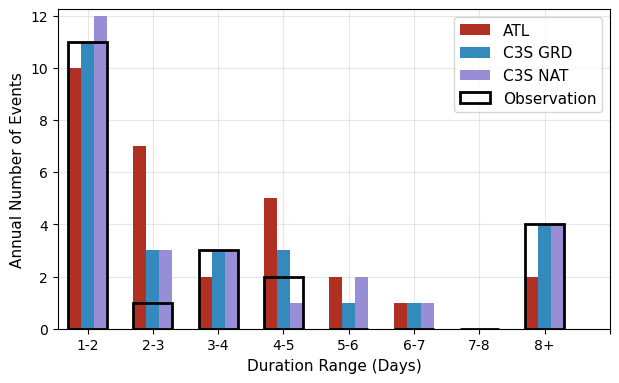

In [9]:
fig, ax = plt.subplots(1, 1, 
                       figsize = (16*cm, 10*cm),
                       sharey = True)

for i, name in enumerate(categories['solar']):
    # Select pandas DataFrame
    df = droughts_dict[name]

    # For each year, calculate the number of droughts in each duration range
    df['DurationRange'] = pd.cut(df['Duration'], bins = duration_ranges_hours)
    df['Year'] = df.index.year
    annual_counts = df.groupby(['Year', 'DurationRange'], observed = True).size().unstack(fill_value = 0)

    all_duration_ranges = pd.cut([], bins = duration_ranges_hours).categories
    annual_counts = annual_counts.reindex(columns = all_duration_ranges, fill_value = 0)

    if i == 0:
        eirgrid_heights = annual_counts.values[0]
    else:
        ax.bar(positions + (i - 1) * bar_width - 0.2, annual_counts.values[0],
               width = bar_width,
               color = color_models[i],
               label = label_name[i],
               zorder = 2)

if eirgrid_heights is not None:
    ax.bar(positions, eirgrid_heights,
           width = bar_width * 3,        
           facecolor = 'none',
           edgecolor = 'black',
           linewidth = 2,
           label = 'Observation',
           zorder = 3)

# Axis properties
ax.margins(0.02)
ax.set_xlabel('Duration Range (Days)', fontsize = 11)
ax.set_xticks(np.arange(len(duration_ranges_days)))
ax.set_xticklabels(xlabel)
ax.set_ylabel('Annual Number of Events', fontsize = 11)
ax.grid(True, alpha = 0.3, zorder = 0)
ax.legend(loc = 'upper right', fontsize = 11)

fig.tight_layout()
# fig.savefig('07_verification_solar_number_events.pdf', bbox_inches='tight')